# Event handling and callbacks in ODE solvers

The differential equation solvers in `ProbNum` are able to handle events.
At the moment, an event can either be a set of grid-points that must be included in the posterior, or a state for which a condition-function
\begin{align*}
    \text{condition}: \mathbb{R}^d \rightarrow \{0, 1\},
\end{align*}
evaluates to `True`.
This notebook explains how this can be used with `ProbNum` (some examples are taken from https://diffeq.sciml.ai/stable/features/callback_functions/)


## Quickstart

What is the easiest way to force events into your ODE solution?
Let us define a simple, linear ODE that describes exponential decay.

In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

# Plotting
import matplotlib.pyplot as plt

plt.style.use("../../probnum.mplstyle")

In [2]:
from probnum import diffeq, randvars, statespace, randprocs, problems
import numpy as np

# For easy modification of the states in the callbacks
import dataclasses

In [3]:
def f(t, y):
    return -y


def df(t, y):
    return -1.0 * np.eye(len(y))  # np.ones((len(y), len(y)))


t0 = 0.0
tmax = 5.0
y0 = np.array([4])

To show off the ability to include a set number of grid-points, let us define a dense grid in a subset of the integration domain.

In [4]:
time_stamps = np.linspace(3.5, 4.0, 50)

To force the ODE solver to include these time-stamps, just pass them to `probsolve_ivp`. Here, we pick a large relative tolerance because we want to see a range of samples (the ODE is so simple, it is solved very accurately on large steps).

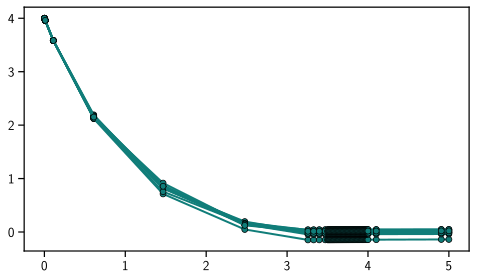

In [5]:
probsol = diffeq.probsolve_ivp(
    f,
    t0,
    tmax,
    y0,
    time_stamps=time_stamps,
    rtol=0.8,
)

# Draw 10 samples from the posterior and plot.
rng = np.random.default_rng(seed=2)
samples = probsol.sample(size=10, rng=rng)
for sample in samples:
    plt.plot(probsol.locations, sample, "o-", color="C0")
plt.show()

Observe how there is a dense gathering of grid-points between 3.5 and 4.0. These are our events!

The same works for e.g. `perturbsolve_ivp`. Let us compute 10 perturbed solutions, so the plots look similar to the samples from the posterior of the probabilistic solver. 

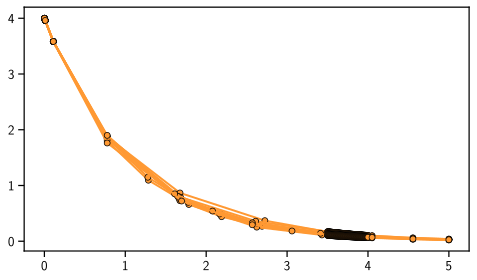

In [6]:
# every solve is random
rng = np.random.default_rng()


time_stamps = np.linspace(3.5, 4.0, 100)
perturbsols = [
    diffeq.perturbsolve_ivp(
        f=f,
        t0=t0,
        tmax=tmax,
        y0=y0,
        rng=rng,
        noise_scale=0.05,
        time_stamps=time_stamps,
    )
    for _ in range(10)
]

for perturbsol in perturbsols:
    plt.plot(perturbsol.locations, perturbsol.states.mean, "o-", color="C1")
plt.show()

Again, observe how there are many locations between 3.5 and 4.0.

## Discrete callback events

It is also possible to  modify the solver states whenever an event happens.
This is not possible via the top-level interface functions (e.g. `probsolve_ivp`) - we have to build an ODE solver from scratch (see the respective notebook for an explanation thereof).

In [7]:
# Construct IVP, prior, linearization, diffusion, and initialization
ivp = problems.InitialValueProblem(t0=t0, tmax=tmax, y0=y0, f=f, df=df)
prior = statespace.IBM(
    ordint=1,
    spatialdim=ivp.dimension,
    forward_implementation="sqrt",
    backward_implementation="sqrt",
)
initrv = randvars.Normal(mean=np.zeros(prior.dimension), cov=np.eye(prior.dimension))

prior_process = randprocs.MarkovProcess(transition=prior, initrv=initrv, initarg=ivp.t0)

ekf = diffeq.odefiltsmooth.GaussianIVPFilter.string_to_measurement_model(
    "EK1", ivp=ivp, prior_process=prior_process
)

diffmodel = statespace.ConstantDiffusion()

init_routine = diffeq.odefiltsmooth.initialization_routines.RungeKuttaInitialization()

To describe a discrete event, we define a condition function that checks whether the current time-point is either 2.0 or 4.0. At both locations, we reset the current state to $y=6.$ (careful! The state of a filter-based solver consists of $[y, \dot y, \ddot y, ...]$).

Let us construct both functions and pass them to a `DiscreteEventHandler`.
Since the solver is unlikely to stop at exactly 2.0 or 4.0, let us force these locations into the ODE solver posterior.


In [9]:
def condition(state: diffeq.ODESolver.State) -> bool:
    return state.t in [2.0, 4.0]


def replace(state: diffeq.ODESolver.State) -> diffeq.ODESolver.State:
    """Replace an ODE solver state whenever a condition is True."""
    new_mean = np.array([6.0, -6])
    new_rv = randvars.Normal(
        new_mean, cov=0 * state.rv.cov, cov_cholesky=0 * state.rv.cov_cholesky
    )
    return dataclasses.replace(state, rv=new_rv)


callback = diffeq.callbacks.DiscreteCallback(condition=condition, replace=replace)

solver = diffeq.odefiltsmooth.GaussianIVPFilter(
    ivp,
    prior_process=prior_process,
    measurement_model=ekf,
    initialization_routine=init_routine,
    diffusion_model=diffmodel,
    with_smoothing=False,  # smoothing would destroy the "reset" appearance in the plot
)
steprule = diffeq.stepsize.AdaptiveSteps(0.1, atol=1e-1, rtol=1e-1)
odesol = solver.solve(steprule=steprule, stop_at=[2.0, 4.0], callbacks=callback)

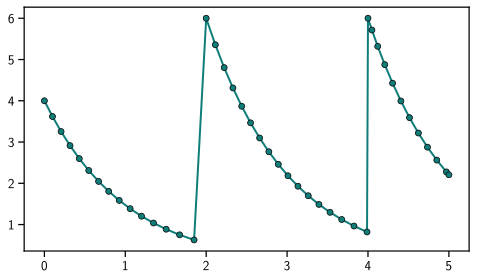

In [10]:
plt.plot(odesol.locations, odesol.states.mean, "o-")
plt.show()